# Train GCN for Heat Stake Recognition

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\A01369877\AppData\Local\miniconda3\envs\heatstakes\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 60
EPOCHS = 200
BATCH_SIZE = 16
LR = 0.001
DROPOUT = 0.3
VAL_SPLIT = 0.2

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.cuda.get_arch_list())
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
True
Using device: cuda


# Create Dataset

In [3]:
import sys
import cadquery as cq
from pathlib import Path
import torch


# Resolve paths relative to this notebook's folder when possible
BASE_DIR = Path.cwd().parent
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))
    
from preprocessing.graphs import build_brep_graph, nx_to_PyG

DATA_DIR = BASE_DIR / "GCN" / "training_data"
HEATSTAKE_DIR = DATA_DIR / "heatstakes"
OTHER_DIR = DATA_DIR / "other"
DATASET_FILE = BASE_DIR / "GCN" / "training_ready_dataset.pt"

if False:
    dataset = []

    def iter_step_files(folder: Path):
        return [p for p in folder.rglob('*') if p.suffix.lower() in {'.stp', '.step'}]

    possible_heatstakes = iter_step_files(HEATSTAKE_DIR)
    possible_others = iter_step_files(OTHER_DIR)

    print(f"Found {len(possible_heatstakes)} heatstake STEP files and {len(possible_others)} other STEP files.")
    for heatstake_path in possible_heatstakes:
        solids = cq.importers.importStep(str(heatstake_path)).faces()
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        data[0].y = torch.tensor([1], dtype=torch.long)  # class 1 = heatstake
        dataset.append(data[0])
    for other_path in possible_others:
        solids = cq.importers.importStep(str(other_path)).faces()    
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        data[0].y = torch.tensor([0], dtype=torch.long)  # class 0 = other
        dataset.append(data[0])

    if len(dataset) == 0:
        print("No graphs were created. Ensure your folders contain .stp/.step files and your preprocessing functions are available.")
    else:
        torch.save(dataset, DATASET_FILE)
        print(f"Saved dataset with {len(dataset)} graphs to {DATASET_FILE}")


In [4]:
# Load dataset (expects a single .pt file saved as a list of PyG Data objects)
from pathlib import Path
import torch

BASE_DIR = Path.cwd().parent
DATASET_FILE = BASE_DIR / "GCN" / "training_ready_dataset.pt"

if DATASET_FILE.exists():
    dataset = torch.load(DATASET_FILE, weights_only=False)
    print(f"Loaded dataset with {len(dataset)} graphs from {DATASET_FILE}")
else:
    dataset = []
    print(f"Dataset file not found at {DATASET_FILE}. Add data or build dataset first.")

# Basic sanity check
if len(dataset) > 0:
    assert hasattr(dataset[0], 'x') and hasattr(dataset[0], 'edge_index') and hasattr(dataset[0], 'y'), \
        "Each Data must have x, edge_index, and y"

Loaded dataset with 64 graphs from c:\Users\A01369877\Documents\GM\3d-part-localization\GCN\training_ready_dataset.pt


In [5]:
# Split into train/val and create loaders
if len(dataset) > 0:
    labels = [int(d.y.item()) for d in dataset]
    train_idx, val_idx = train_test_split(
        list(range(len(dataset))),
        test_size=VAL_SPLIT,
        random_state=SEED,
        stratify=labels if len(set(labels)) > 1 else None,
    )
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")
else:
    train_loader = None
    val_loader = None


Train graphs: 51 | Val graphs: 13


In [6]:
from GCN import GCN

# Create model, criterion, optimizer
if train_loader is not None:
    in_channels = train_dataset[0].x.size(-1)
    model = GCN(feature_dim_size=in_channels, num_classes=2, dropout=DROPOUT).to(DEVICE)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    print(model)
else:
    model = None


GCN(
  (convolution_1): GCNConv(3, 64)
  (convolution_2): GCNConv(64, 32)
  (convolution_3): GCNConv(32, 32)
  (attention): AttentionModule()
  (fully_connected_first): Linear(in_features=32, out_features=32, bias=True)
  (fully_connected_second): Linear(in_features=32, out_features=8, bias=True)
  (scoring_layer): Linear(in_features=8, out_features=2, bias=True)
)


In [7]:
# Train/eval helpers

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in loader:
        # The provided GCN does not aggregate per-graph using the batch vector, so
        # we process each graph in the batch individually.
        data_list = batch.to_data_list()

        optimizer.zero_grad()
        batch_loss = 0.0
        batch_correct = 0
        batch_total = 0

        for data in data_list:
            data = data.to(DEVICE)
            out = model(adj=data.edge_index, features=data.x)  # shape [1, 2]
            loss = criterion(out, data.y.long())
            loss.backward()
            batch_loss += loss.item()

            preds = out.argmax(dim=1)
            batch_correct += int((preds == data.y).sum().item())
            batch_total += data.y.size(0)

        optimizer.step()

        total_loss += batch_loss
        correct += batch_correct
        total += batch_total

    avg_loss = total_loss / max(1, len(loader))
    acc = correct / max(1, total)
    return avg_loss, acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            data_list = batch.to_data_list()
            batch_loss = 0.0
            batch_correct = 0
            batch_total = 0
            for data in data_list:
                data = data.to(DEVICE)
                out = model(adj=data.edge_index, features=data.x)
                loss = criterion(out, data.y.long())
                batch_loss += loss.item()
                preds = out.argmax(dim=1)
                batch_correct += int((preds == data.y).sum().item())
                batch_total += data.y.size(0)
            total_loss += batch_loss
            correct += batch_correct
            total += batch_total
    avg_loss = total_loss / max(1, len(loader))
    acc = correct / max(1, total)
    return avg_loss, acc


Epoch 001 | Train Loss: 13.8696 Acc: 0.431 | Val Loss: 8.8532 Acc: 0.769
Epoch 002 | Train Loss: 8.6204 Acc: 0.588 | Val Loss: 8.9520 Acc: 0.615
Epoch 003 | Train Loss: 8.9075 Acc: 0.588 | Val Loss: 9.0090 Acc: 0.615
Epoch 004 | Train Loss: 8.8269 Acc: 0.588 | Val Loss: 8.9218 Acc: 0.615
Epoch 005 | Train Loss: 8.7405 Acc: 0.588 | Val Loss: 8.8684 Acc: 0.615
Epoch 006 | Train Loss: 8.6610 Acc: 0.588 | Val Loss: 8.8239 Acc: 0.615
Epoch 007 | Train Loss: 8.5952 Acc: 0.588 | Val Loss: 8.8187 Acc: 0.615
Epoch 008 | Train Loss: 8.5955 Acc: 0.588 | Val Loss: 8.8052 Acc: 0.615
Epoch 009 | Train Loss: 8.5977 Acc: 0.588 | Val Loss: 8.8107 Acc: 0.615
Epoch 010 | Train Loss: 8.5801 Acc: 0.588 | Val Loss: 8.8115 Acc: 0.615
Epoch 011 | Train Loss: 8.5811 Acc: 0.588 | Val Loss: 8.8106 Acc: 0.615
Epoch 012 | Train Loss: 8.5805 Acc: 0.588 | Val Loss: 8.8079 Acc: 0.615
Epoch 013 | Train Loss: 8.5863 Acc: 0.588 | Val Loss: 8.8053 Acc: 0.615
Epoch 014 | Train Loss: 8.5808 Acc: 0.588 | Val Loss: 8.8019 Ac

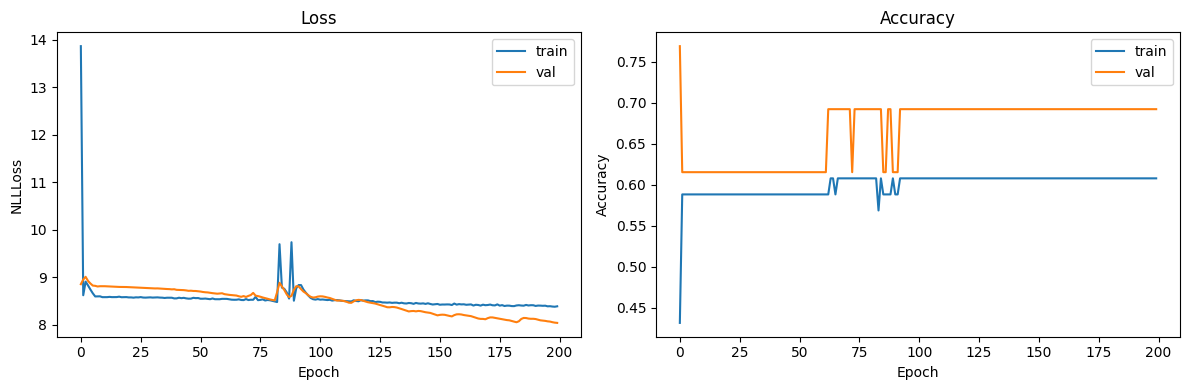

In [8]:
# Training loop with plots
if train_loader is not None and model is not None:
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        vl_loss, vl_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)

        print(f"Epoch {epoch:03d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} | Val Loss: {vl_loss:.4f} Acc: {vl_acc:.3f}")

    # Plot loss and accuracy
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history["train_loss"], label="train")
    axs[0].plot(history["val_loss"], label="val")
    axs[0].set_title("Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("NLLLoss")
    axs[0].legend()

    axs[1].plot(history["train_acc"], label="train")
    axs[1].plot(history["val_acc"], label="val")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No dataset loaded. Build or load heatstake_dataset.pt first.")


In [9]:
torch.save(model.state_dict(), BASE_DIR / "GCN" / "heatstake_classifier.pth")